In [193]:
%matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.cuda
from chainer import optimizers
from chainer import serializers
from chainer import cuda
import numpy as np
import matplotlib.pyplot as plt

In [194]:
n_epoch = 100
batchsize = 100
bprop_len = 30
n_units = 100
grad_clip = 5
use_gpu = True

In [195]:
xp = cuda.cupy if use_gpu is True else np

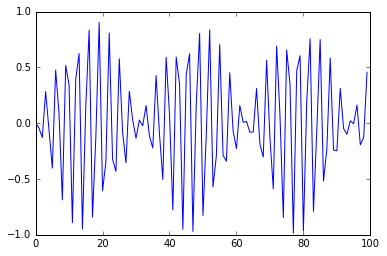

In [196]:
t = np.arange(0,1000,0.1, dtype=np.float32)

train_data = np.sin(t) * np.cos(20 * t)
#train_data = np.asarray([1 if (i/5)%2 == 0 else -1 for i in range(10000)], dtype=np.float32)
#train_data = 42 * np.sin(t)
plt.plot(train_data[:100])

In [197]:
class RNN(chainer.Chain):
    def __init__(self, n_units):
        super(RNN, self).__init__(
            l1 = L.Linear(1, n_units),
            l2 = L.LSTM(n_units, n_units),
            l3 = L.Linear(n_units, 1)
        )
    
    def __call__(self,x,t):
        return F.mean_squared_error(self.predict(x),t)
        
    def reset_state(self):
        self.l2.reset_state()
    
    def predict(self,x):
        h1 = F.sigmoid(self.l1(x))
        h2 = self.l2(h1)
        y = self.l3(h2)
        return y

In [198]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [199]:
model = RNN(n_units)
if use_gpu is True:
    model.to_gpu()
#optimizer = optimizers.SGD(lr=1.)
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
losslist = []
length = train_data.shape[0]
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data[(jump * j + i) % length]] for j in batch_idxs]))
    t = chainer.Variable(xp.asarray([[train_data[(jump * j + i + 1) % length]] for j in batch_idxs]))
    loss_i = model(x,t)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        #if epoch > 5:
        #    optimizer.lr /= 1.3
        print('epoch {}, error {}'.format(epoch, loss_data / length))
        losslist.append(loss_data / length)
        loss_data = 0
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()


epoch 1, error 0.03876486420631409
epoch 2, error 0.03536365181207657
epoch 3, error 0.03305298835039139
epoch 4, error 0.025337330996990204
epoch 5, error 0.023458367213606834
epoch 6, error 0.020772764459252357
epoch 7, error 0.013995464891195297
epoch 8, error 0.010096695274114609
epoch 9, error 0.0059785074554383755
epoch 10, error 0.0028390304651111364
epoch 11, error 0.0029765476938337088
epoch 12, error 0.0026489533483982086
epoch 13, error 0.0022357103880494833
epoch 14, error 0.0024914180394262075
epoch 15, error 0.0020895428024232388
epoch 16, error 0.0018092977115884423
epoch 17, error 0.0018843684811145067
epoch 18, error 0.001729596289806068
epoch 19, error 0.001434601261280477
epoch 20, error 0.001444554072804749
epoch 21, error 0.0014316047308966517
epoch 22, error 0.0013012150302529335
epoch 23, error 0.0014541627606377006
epoch 24, error 0.0016838557785376906
epoch 25, error 0.0011779613560065627
epoch 26, error 0.0012060909066349268
epoch 27, error 0.00123984948731958

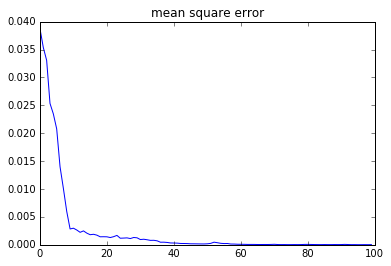

In [200]:
plt.plot(losslist)
plt.title('mean square error')

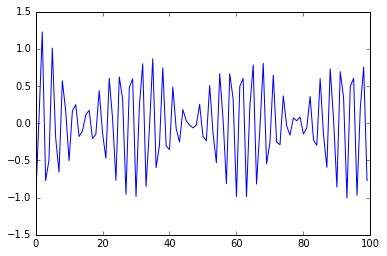

In [201]:
output = evaluate(model,400,origin=1)
plt.plot(output[:100])

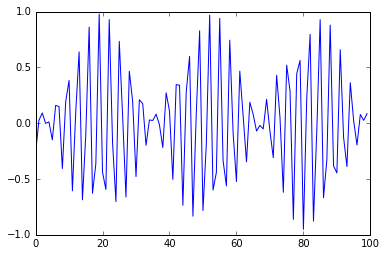

In [202]:
plt.plot(output[300:400])